<a href="https://colab.research.google.com/github/larsmoan/COMP3710/blob/main/eigenfaces_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
#Downloading the dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
n_samples, height, width = lfw_people.images.shape
X = lfw_people.data
X = torch.from_numpy(X)

n_features = X.shape[1]

#Fetching the label or target
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]


print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [4]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print(type(X), type(X_train))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [5]:
#Centering the data
mean = torch.mean(X)  #From the notebook given they compute the mean from X_train, isn`t this wrong? Therefore I use X
X_train -= mean
X_test -= mean

#Eigen decomposition
U, S, Vh = torch.linalg.svd(X_train, full_matrices=False)

components = Vh[:n_components]
eigenfaces = components.reshape((n_components, height, width))

In [7]:
X_transformed = torch.matmul(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = torch.matmul(X_test, components.T)
X_test_transformed.shape

torch.Size([966, 150])


torch.Size([322, 150])

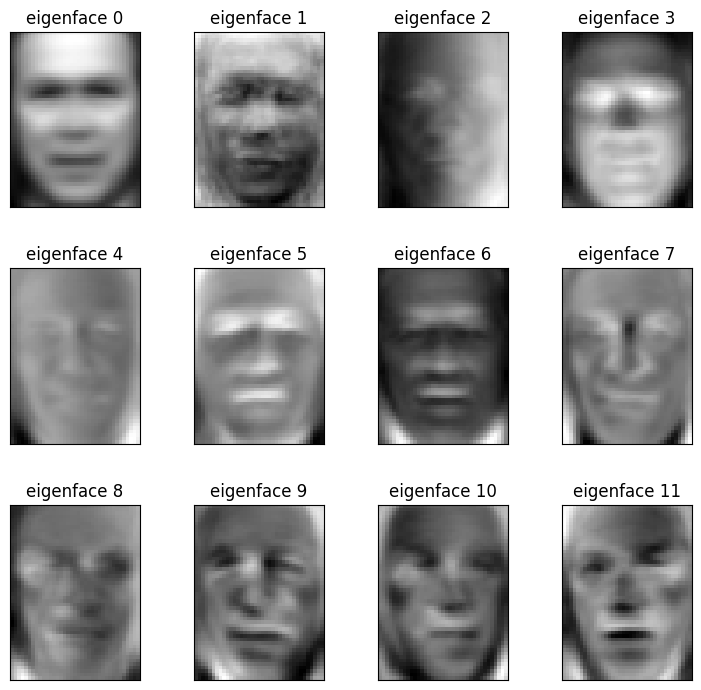

In [10]:
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
  """Helper function to plot a gallery of portraits"""
  plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
  for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())


eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, height, width)

torch.Size([966])


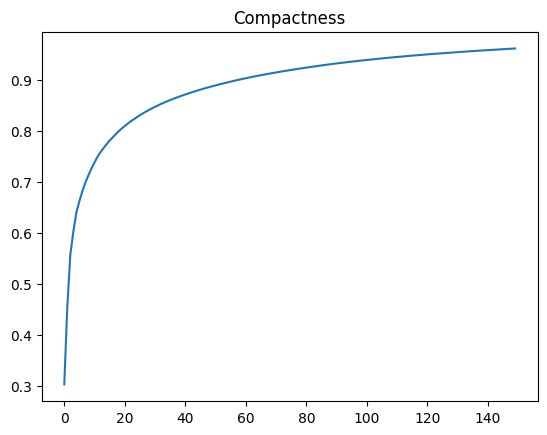

In [11]:
#Evaluating performance of the dimensionality reduction using a compactness plot
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [15]:
#Using the PCA face-space as features to build a random forest classifer of the original faces
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train)

RandomForestClassifier(max_depth=15, max_features=150, n_estimators=150)

In [16]:
predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)
print(classification_report(y_test, predictions, target_names=target_names))


Total Testing 322
Predictions [3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 6 3 3 2 1 3 3 3 1 1 1 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 1 3 1 1 3 3 3 4 3 3 3 1 3 3 2 1 3 3 3 1 1 1 3 3 6 3 4 1 3 1 6 3 1
 3 1 4 6 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 1 3 1 1 3 6 3 3 3 1 3 3 3 3 3 1 3
 3 3 3 3 3 3 4 1 3 1 3 3 1 3 4 3 1 1 3 3 6 3 3 3 1 3 3 1 1 3 3 3 1 3 3 3 3
 1 1 1 1 1 3 3 3 1 1 1 3 6 3 5 1 3 3 5 1 3 3 3 3 3 1 3 3 3 2 2 3 1 3 3 3 3
 3 3 3 3 2 3 1 3 3 1 3 3 3 3 6 3 2 3 1 3 1 4 2 1 2 1 3 3 3 3 3 3 3 3 3 3 3
 1 1 1 3 3 3 1 3 3 3 1 0 3 1 3 3 3 3 3 3 2 3 3 1 3 3 3 3 4 3 3 1 3 3 3 1 3
 3 3 1 3 1 3 4 3 1 3 3 1 6 3 3 3 3 3 3 3 3 1 1 3 3 1 1 3 3 3 4 3 3 5 3 2 1
 4 3 3 3 3 6 3 3 1 3 3 3 1 3 3 3 1 3 3 3 3 1 3 3 3 3]
Which Correct: [ True  True False  True  True  True False  True  True  True  True  True
  True False  True  True False  True  True False  True False  True False
 False  True False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False  True
 False  T